# Spam Email Detector

### Project Overview 
The goal of this project is to create visualizations, explore text transformations or data processing techniques, and select the best machine learning model and the best hyperparameters to obtain the highest possible accuracy and recall for spam email detection.

### Dataset Description 
#### [Spam Filter: Identifying Spam Using Emails](https://www.kaggle.com/datasets/karthickveerakumar/spam-filter)

![img 1](img/diana-light-s358rpxEALI-unsplash.jpg)

**Context**:
There's a story behind every dataset and here's your opportunity to share yours.

**Content**:
The dataset contains more than just rows and columns. It includes information that helps identify spam emails. The dataset was acquired from [Karthickveerakumar (Owner)] and represents emails collected over a specific time period. It includes key attributes necessary for spam detection.

**Owner of the dataset**: [Karthickveerakumar (Owner)](https://www.kaggle.com/karthickveerakumar)

## Libraries

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from wordcloud import WordCloud
from nltk.corpus import stopwords 

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

%matplotlib inline 

## Data Preprocessing
**Exploratory Data Analysis (EDA)**: Analysis to understand the data distribution and characteristics.

In [3]:
df = pd.read_csv('data/emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df.shape

(5728, 2)

**Data Cleaning**: Handling missing values and removing duplicates.

In [5]:
duplicates = df.duplicated()
print(duplicates.sum())

33


In [6]:
# Drop duplicate rows
df = df.drop_duplicates()

In [7]:
# Total number of missing values
total_missing_values = df.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


**Data Distribution**

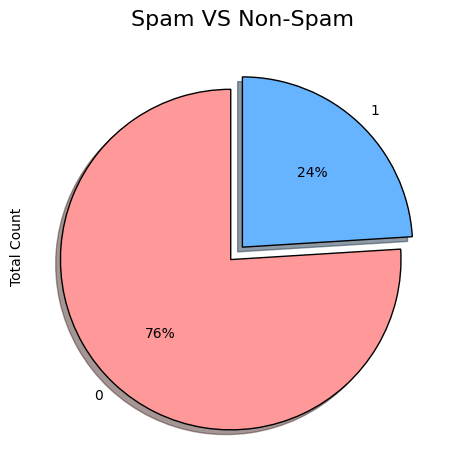

In [8]:
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0) 

# pie chart
df.spam.value_counts().plot(kind='pie',
                            autopct='%1.0f%%', 
                            colors=colors, 
                            explode=explode,
                            shadow=True,
                            startangle=90, 
                            wedgeprops={'edgecolor': 'black'})

plt.title('Spam VS Non-Spam', fontsize=16)
plt.ylabel('Total Count')
plt.tight_layout()
plt.show()

**Spam (1):** 24% of the emails in the dataset are spam emails.

**Non-Spam (0):** 76% of the emails in the dataset are Not Spam. 

The **primary objective** is to ensure that the model effectively identifies spam emails, therefore focusing on Recall as the primary metric. In the context of spam detection, the goal is to minimize the number of actual spam emails that are classified as not spam (false negatives).

A high recall score indicates that the model is able to identify most of the actual Spam emails (Positive). The number of false negatives (actual Spam emails incorrectly predicted as Non-Spam emails) is low.

### Stop words
Commonly used words in a language that are often filtered out or ignored in natural language processing (NLP) tasks.
- Examples of stop words in English include "the," "is," "in," "and," "to," and "a."

**Why Stop Words are Removed:**
- Reduce Dimensionality
- It makes the text processing tasks more efficient by focusing on words that carry more meaningful information.
- By eliminating noise, models can focus on the most relevant words

In [9]:
# nltk.download('stopwords')

In [10]:
stop = stopwords.words('english')
df['rm_sw_text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [11]:
def ShowWordCloud(data, tittle):
    text = ' '.join(data['rm_sw_text'])

    wordcloud2 = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stop,
        colormap='coolwarm',
        max_words=100,  # maximum number of words to include
        random_state=42,  
        collocations=False  # avoid duplicate words in the word cloud
    ).generate(text)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{tittle} Emails Word Cloud', fontsize=16)
    plt.show()

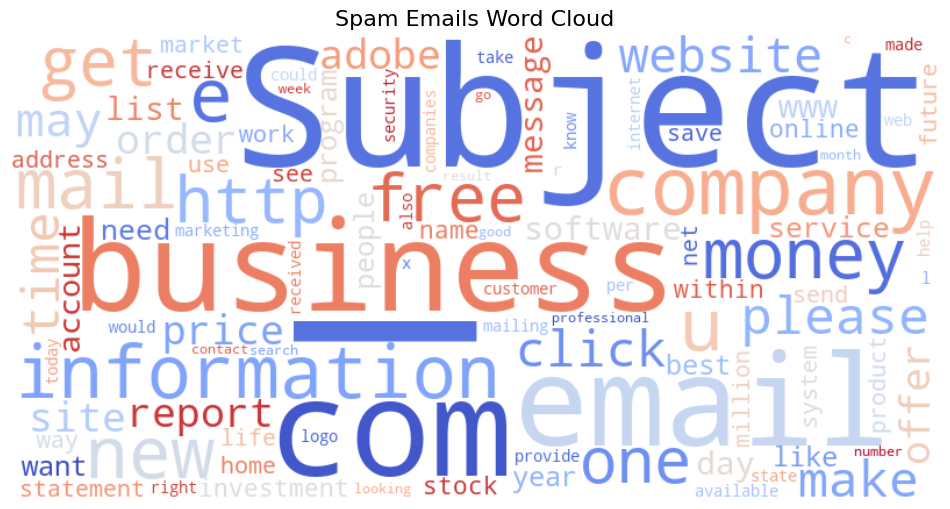

In [12]:
spam_df = df[df["spam"] == 1]
ShowWordCloud(spam_df, tittle='Spam')

- The output shows that **Spam Emails** contains mostly a *Subject* and some terms like *business, free, money, information, company, email, time, new*, etc. 

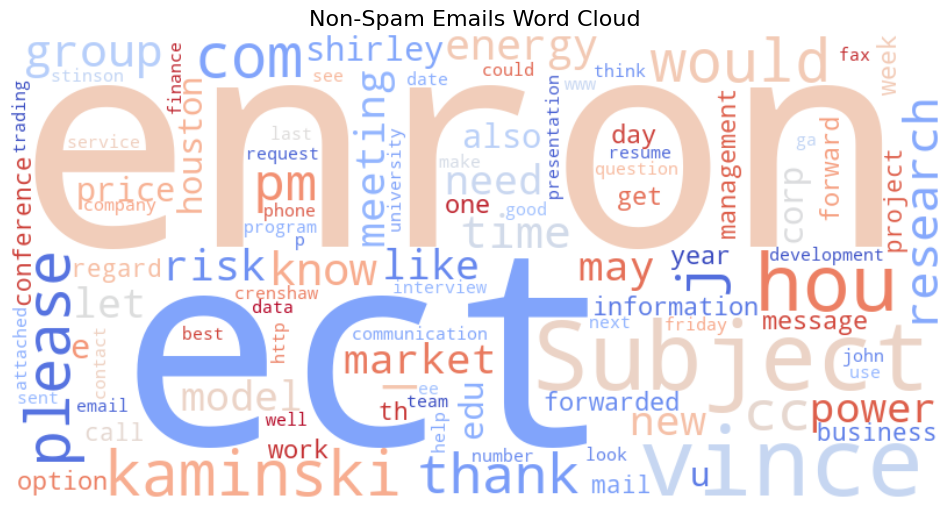

In [13]:
spam_df = df[df["spam"] == 0]
ShowWordCloud(spam_df, tittle='Non-Spam')

- The output shows that **Non-Spam Emails** contains mostly words such as *ect, enron, vince, thank, please, hou, kaminski*, etc.

#### TF-IDF Vectorization

Techniques like tokenization, stemming, lemmatization, and vectorization (e.g., TF-IDF) are used to preprocess the text data.

In this section, I implemented the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to convert the cleaned text data into numerical features. The parameters are set to ignore terms that appear in more than 85% of the documents or in fewer than 5 documents, and to keep only the top 10000 features. I also use the English stop words list to remove common words that are not useful for analysis.

In [14]:
X = df["text"]
y = df["spam"]

In [15]:
def clean_text(text):
    # Remove digits and special characters
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    
    return text

In [16]:
cleaned_text = X.apply(clean_text)

In [17]:
def tokenize(text):
    # split into words
    words = text.lower().split()
    return words

# adding all the words in a list
all_words = [word for text in cleaned_text for word in tokenize(text)]

# remove duplicates using 'set'
unique_words = set(all_words)

print('Number of unique words:', len(unique_words))

Number of unique words: 33741


In [18]:
vectorizer = TfidfVectorizer(
    max_df=0.85,       # Ignore terms that appear in more than 85% of the documents
    min_df=5,          # Ignore terms that appear in fewer than 5 documents
    max_features=10000,   # Keep only the top 10000 features (terms)
    stop_words='english'  # Use English stop words list
)

X = vectorizer.fit_transform(cleaned_text).toarray()

## Model Building

### Model Selection
Choosing the appropriate machine learning models for spam detection is critical to the success of this project. The models considered are:

- Logistic Regression
- Multinomial Naive Bayes
- Random Forest
- Gradient Boosting
- Support Vector Machine (SVM)

The **primary objective** is to ensure that the model effectively identifies spam emails, focusing on Recall as the primary metric to minimize false negatives.

### Training the Models
Split the data into training and test sets and then trained various models using cross-validation.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

### Model Evaluation
I evaluate the models based on several metrics, including accuracy, precision, recall, and F1-score, to determine the best performing model for spam detection. The model with the highest recall is selected to minimize the number of actual spam emails classified as not spam (false negatives).

In [19]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(kernel='linear', probability=True)
}

best_model = None
best_recall = 0
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each classifier
for name, clf in classifiers.items():
    start_time = time.time()
    scores = cross_validate(clf, 
                            X_train, 
                            y_train, 
                            cv=kfold, 
                            scoring=['accuracy', 'precision', 'recall', 'f1'], 
                            n_jobs=-1)
    end_time = time.time()
    elapsed_time = end_time - start_time

    avg_accuracy = scores['test_accuracy'].mean()
    avg_precision = scores['test_precision'].mean()
    avg_recall = scores['test_recall'].mean()
    avg_f1 = scores['test_f1'].mean()
    
    print(f'--- {name} ---')
    print(f'Time taken: {elapsed_time:.4f} seconds')
    print(f'Avg Accuracy: {avg_accuracy:.4f}')
    print(f'Avg Precision: {avg_precision:.4f}')
    print(f'Avg Recall: {avg_recall:.4f}')
    print(f'Avg F1 Score: {avg_f1:.4f}\n')
    
    # Select the best model based on Recall
    if avg_recall > best_recall:
        best_recall = avg_recall
        best_model = (name, clf)

print(f'Best model based on Recall: {best_model[0]} with Recall = {best_recall:.4f}')

--- Logistic Regression ---
Time taken: 10.6070 seconds
Avg Accuracy: 0.9787
Avg Precision: 0.9940
Avg Recall: 0.9151
Avg F1 Score: 0.9529

--- Multinomial Naive Bayes ---
Time taken: 3.7051 seconds
Avg Accuracy: 0.9763
Avg Precision: 0.9980
Avg Recall: 0.9012
Avg F1 Score: 0.9470

--- Random Forest ---
Time taken: 20.9242 seconds
Avg Accuracy: 0.9853
Avg Precision: 0.9764
Avg Recall: 0.9608
Avg F1 Score: 0.9685

--- Gradient Boosting ---
Time taken: 320.2189 seconds
Avg Accuracy: 0.9633
Avg Precision: 0.9580
Avg Recall: 0.8834
Avg F1 Score: 0.9188

--- Support Vector Machine ---
Time taken: 285.6333 seconds
Avg Accuracy: 0.9917
Avg Precision: 0.9897
Avg Recall: 0.9748
Avg F1 Score: 0.9821

Best model based on Recall: Support Vector Machine with Recall = 0.9748


### Results
#### Best Model Based on Recall
The Support Vector Machine (SVM) emerged as the best model based on the Recall metric, with a Recall of 0.9748. This indicates that the SVM model is highly effective at identifying spam emails, minimizing the number of false negatives. Recall is particularly important in spam detection as it ensures that most spam emails are correctly identified.

Following the SVM, the Random Forest classifier performed well with a Recall of 0.9608, making it the second-best model in terms of recall.

#### Explanation of Metrics
- **Accuracy:** Measures the overall correctness of the model. It is the ratio of correctly predicted instances (both spam and not spam) to the total instances.
- **Precision:** Indicates the accuracy of the positive predictions (spam). It is the ratio of true positive predictions to the total positive predictions (both true and false positives).
- **Recall:** Measures the ability of the model to identify all relevant instances (spam). It is the ratio of true positive predictions to the total actual positives (both true positives and false negatives).
- **F1 Score:** Harmonic mean of precision and recall. It balances the two metrics, providing a single measure of a model's performance.

In summary, while the Support Vector Machine offers the highest recall, ensuring most spam emails are correctly flagged, it also exhibits high values in other metrics, making it a robust choice. The Random Forest classifier also provides strong performance, particularly in recall and precision, making it a reliable alternative.

## Model Optimization

### Hyperparameter Tuning
To optimize the model parameters, I utilized Grid Search for both the Support Vector Machine (SVM) and Random Forest classifiers. The goal was to find the best parameters (based on the 'recall' scoring) that maximize the model's ability to identify spam emails.

#### Cross-Validation
Cross-validation is implemented to ensure the robustness and generalization of the models. By evaluating multiple metrics (accuracy, precision, recall, F1 score) during the hyperparameter tuning process, I ensured that the models not only performed well in terms of recall but also maintained a balance with precision

In [20]:
# def custom_scoring_function(y_true, y_pred):
#     # Custom score: combining recall and precision
#     recall = recall_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred)
#     custom_score = 0.6 * recall + 0.4 * precision
#     return custom_score

# # Create a scorer using make_scorer
# custom_scorer = make_scorer(custom_scoring_function, greater_is_better=True)

In [31]:
def evaluate_model_parameters(model, param_grid, score_metric='recall'):
    start_time = time.time()
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid, 
                               cv=kfold, 
                               n_jobs=-1, 
                               verbose=2, 
                               scoring=['accuracy', 'precision', 'recall', 'f1'],
                               refit=score_metric)

    # Perform Grid Search
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best model
    best_grid = grid_search.best_estimator_
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Time taken: {elapsed_time:.4f} seconds')
    
    # Print the best score and the best parameters
    print(f"Best recall score: {grid_search.best_score_}")
    print(f"Best parameters: {grid_search.best_params_}")

    # Extract the cv results
    cv_results = grid_search.cv_results_

    # Get the index of the best model
    best_index = grid_search.best_index_

    # Print all the scores for the best model
    print(f"Best model scores:")
    print(f"Accuracy: {cv_results['mean_test_accuracy'][best_index]}")
    print(f"Precision: {cv_results['mean_test_precision'][best_index]}")
    print(f"Recall: {cv_results['mean_test_recall'][best_index]}")
    print(f"F1 Score: {cv_results['mean_test_f1'][best_index]}")
    
    return best_grid

#### SVM Hyperparameter Tuning Results
Defined a parameter grid for the SVM, considering various kernels, regularization strengths (C), and other relevant hyperparameters with 5-fold cross-validation on 24 parameter combinations. 

In [21]:
# Define the parameter grid for SVM
param_grid_svm = {
    'probability': [True],
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],  # kernel coefficient
    'class_weight': [None, 'balanced']
}

# Initialize the SVM classifier
svm = SVC()

# Initialize Evaluation for SVM using recall to measure performance
best_svm = evaluate_model_parameters(model=svm, param_grid=param_grid_svm)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time taken: 11853.2589 seconds
Best recall score: 1.0
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
Best model scores:
Accuracy: 0.23529401852600768
Precision: 0.23529401852600768
Recall: 1.0
F1 Score: 0.38095200522405265


Given the high cost of false positives (non-spam emails marked as spam), precision is critical. However, recall remains important to ensure spam emails are identified. Therefore, to balance these concerns, I selected the F1 score as the main metric for further evaluation, as it provides a harmonic mean of precision and recall.

#### SVM with F1 Score Optimization
Redefined the parameter grid and performed another Grid Search, this time optimizing for the F1 score.

In [29]:
# Define the parameter grid for SVM
param_grid_svm = {
    'probability': [True],
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],  # kernel coefficient
    'class_weight': [None, 'balanced']
}

# Initialize the SVM classifier
svm = SVC()

# Initialize Evaluation for SVM
best_svm = evaluate_model_parameters(model=svm, param_grid=param_grid_svm, score_metric='f1')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time taken: 11631.7881 seconds
Best recall score: 0.983559690483345
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
Best model scores:
Accuracy: 0.9923173397269244
Precision: 0.9906270059345982
Recall: 0.9766789828298196
F1 Score: 0.983559690483345


#### Random Forest
For the Random Forest classifier, I defined an extensive parameter grid covering different numbers of estimators, criteria for splitting, maximum depths, and more. The Grid Search with 5-fold cross-validation and using optimizing for the F1 score. 

In [30]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Initialize Evaluation
best_rf = evaluate_model_parameters(model=rf, param_grid=param_grid, score_metric='f1')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Time taken: 2270.1936 seconds
Best recall score: 0.973921767054712
Best parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}
Best model scores:
Accuracy: 0.9877096693435015
Precision: 0.9730962214506127
Recall: 0.9748185177135407
F1 Score: 0.973921767054712


In conclusion, the SVM optimized for the F1 score demonstrated excellent performance, making it a balanced and reliable choice for spam email detection. The Random Forest classifier also showed strong results, reinforcing the robustness of our approach.

### Model Evaluation
After hyperparameter tuning, I compared the two algorithms with the best hyperparameters to select the best model. 
- **Model Performance:** Detailed analysis of the model's performance on the test data.
- **Comparative Analysis:** Comparing the SVM and Random Forest models' performance and discussing the findings.
- **Error Analysis:** Analyzing common types of misclassifications and potential reasons.

--- Random Forest ---
Time taken: 36.9700 seconds
Accuracy: 0.9877
Precision: 0.9732
Recall: 0.9797
F1 Score: 0.9764
Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.99      0.99      0.99       843
        Spam       0.97      0.98      0.98       296

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.98      1139
weighted avg       0.99      0.99      0.99      1139



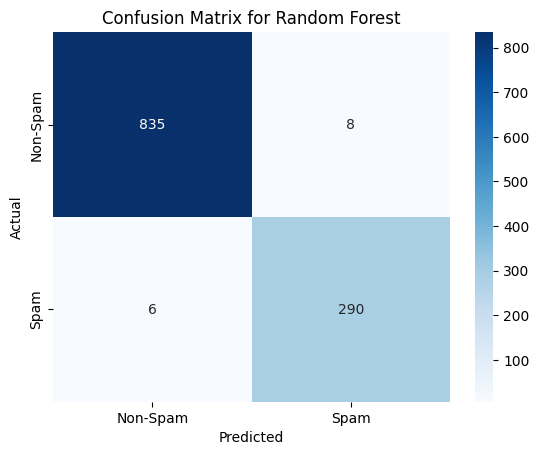


--- Support Vector Machine ---
Time taken: 120.6002 seconds
Accuracy: 0.9939
Precision: 0.9932
Recall: 0.9831
F1 Score: 0.9881
Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.99      1.00      1.00       843
        Spam       0.99      0.98      0.99       296

    accuracy                           0.99      1139
   macro avg       0.99      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139



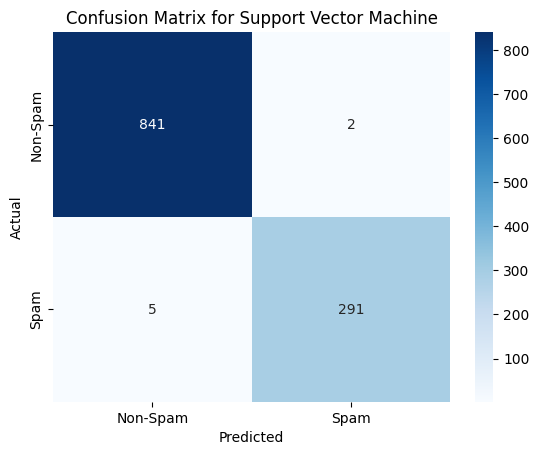


Best model based on Recall: Support Vector Machine with Recall = 0.9831


In [32]:
classifiers = {
    'Random Forest': best_rf,
    'Support Vector Machine': best_svm
}

best_model = None
best_recall = 0

# Train and evaluate each classifier
for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    print(f'--- {name} ---')
    print(f'Time taken: {elapsed_time:.4f} seconds')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred, target_names=['Non-Spam', 'Spam']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    print()
    
    # Select the best model based on Recall
    if recall > best_recall:
        best_recall = recall
        best_model = (name, clf)

print(f'Best model based on Recall: {best_model[0]} with Recall = {best_recall:.4f}')

### Summary of Model Comparison
Based on the evaluation metrics, the Support Vector Machine (SVM) with the best hyperparameters achieved the highest overall performance, indicating its superior ability to identify spam emails. Below is a summary of the key metrics:

1. **Random Forest:**
    - **Recall of 0.9797:** Indicates that 97.97% of actual spam emails were correctly identified.
    - **High Precision of 0.9732:** Means that when the model predicts spam, it is correct 97.32% of the time.
    - **Balanced Performance:** High accuracy, precision, recall, and F1 score indicate a well-balanced model.
</br>
</br>
2. **Support Vector Machine:**
    - **Recall of 0.9831:** Slightly higher than Random Forest, ensuring more spam emails are identified.
    - **Higher Precision of 0.9932:** Indicates fewer false positives compared to Random Forest.
    - **Longer Training Time:** Took significantly longer to train, which might be a consideration depending on the application.
    - **Balanced Performance:** High accuracy, precision, recall, and F1 score.
    
These metrics indicate the effectiveness of each model in terms of identifying spam emails (recall), overall correctness (accuracy), the proportion of positive identifications that were actually correct (precision), and the balance between precision and recall (F1 score). The Support Vector Machine stands out as the best model based on its high recall and precision, ensuring most spam emails are correctly flagged with minimal false positives.

### Saving the Model
To ensure that the trained model can be used in the future without needing to retrain it, I save the model to a file. Here are the steps involved in saving and loading the model.

#### Testing the Model with a Sample Email
First, let's test the best model with a sample email to ensure it correctly classifies the email as spam.


In [33]:
print('Text:\n', cleaned_text[15],'\n')
print('Actual Label: ', y[15])

Text:
 Subject search engine position be the very first listing in the top search engines immediately our company will now place any business with a qualified website permanently at the top of the major search engines guaranteed never to move ex yahoo msn alta vista etc this promotion includes unlimited traffic and is not going to last long if you are interested in being guaranteed first position in the top search engines at a promotional fee please contact us promptly to find out if you qualify via email at searchl telefonica net pe it s very important to include the url s if you are interested in promoting this is not pay per click examples will be provided this promotion is only valid in the usa and canada sincerely the search engine placement specialists if you wish to be removed from this list please respond to the following email address and type the word remove in your subject line search speedy com pe 

Actual Label:  1


In [34]:
print('Predicted Label:', best_model[1].predict(vectorizer.transform([cleaned_text[15]]).toarray()))

Predicted Label: [1]


The Model correctly classify the email as spam

#### Saving the Model to a File
I use the joblib library to save the trained model to a file. This allows me to load the model later and use it for predictions without retraining.

In [35]:
# Save the model to a file
joblib.dump(best_model[1], 'spam_filtered.joblib')

['spam_filtered.joblib']

In [36]:
# Load the model from a file
spam_filtered = joblib.load('spam_filtered.joblib')

By saving the trained model, I ensure that I can quickly deploy the model for practical use in identifying spam emails. The model can be easily loaded and used to make predictions on new emails, making the spam detection system both efficient and scalable.